In [1]:
import os
import torch
import argparse
import torchvision
import numpy as np

from PIL import Image
from torch import autocast
from einops import rearrange
from functools import partial
from omegaconf import OmegaConf
#from pytorch_lightning import seed_everything

from torch.utils.data import DataLoader
from ldm.data.image_dresscode import OpenImageDataset
from ldm.util import instantiate_from_config
from ldm.models.diffusion.ddim import DDIMSampler

In [2]:
# Simulate command-line arguments
opt = argparse.Namespace(seed=42, ddim=16, base="configs/test_dresscode.yaml", ckpt="./dresscode.ckpt")

In [3]:
from ldm.models.diffusion.control import ControlLDM, ControlNet, ControlledUnetModel
from ldm.models.autoencoder import AutoencoderKL
from ldm.modules.encoders.modules import FrozenCLIPImageEmbedder
import torch.nn

In [4]:
cond_stage_model = FrozenCLIPImageEmbedder()

Some weights of the model checkpoint at openai/clip-vit-large-patch14 were not used when initializing CLIPVisionModel: ['text_model.encoder.layers.10.self_attn.v_proj.bias', 'text_model.encoder.layers.8.mlp.fc2.bias', 'text_model.encoder.layers.10.layer_norm1.bias', 'text_model.encoder.layers.0.mlp.fc1.weight', 'text_model.encoder.layers.4.layer_norm1.weight', 'text_model.encoder.layers.1.self_attn.v_proj.bias', 'text_model.encoder.layers.9.self_attn.v_proj.weight', 'text_model.encoder.layers.1.mlp.fc1.weight', 'text_model.encoder.layers.5.layer_norm2.bias', 'text_model.encoder.layers.3.self_attn.v_proj.bias', 'text_model.encoder.layers.1.self_attn.v_proj.weight', 'text_model.encoder.layers.8.layer_norm1.weight', 'text_model.encoder.layers.2.layer_norm2.weight', 'text_model.encoder.layers.6.self_attn.out_proj.weight', 'text_model.final_layer_norm.weight', 'text_model.encoder.layers.5.self_attn.q_proj.bias', 'text_model.encoder.layers.5.layer_norm1.weight', 'text_model.encoder.layers.2.

In [6]:
import torch.nn as nn
first_stage_model = AutoencoderKL(
    embed_dim=4,
    monitor='val/rec_loss',
    ddconfig={
        'double_z': True,
        'z_channels': 4,
        'resolution': 256,
        'in_channels': 3,
        'out_ch': 3,
        'ch': 128,
        'ch_mult': [1, 2, 4, 4],
        'num_res_blocks': 2,
        'attn_resolutions': [],
        'dropout': 0.0
    },
    lossconfig={'target': 'torch.nn.Identity'}
)

making attention of type 'vanilla' with 512 in_channels
Working with z of shape (1, 4, 32, 32) = 4096 dimensions.
making attention of type 'vanilla' with 512 in_channels


In [7]:
control_model = ControlNet(
    use_checkpoint=True,
    in_channels=9,
    hint_channels=5,
    model_channels=320,
    attention_resolutions=[4, 2, 1],
    num_res_blocks=2,
    channel_mult=[1, 2, 4, 4],
    num_head_channels=64,
    transformer_depth=1,
    context_dim=768
)

In [8]:
unet_model = ControlledUnetModel(
    image_size=32,  # unused
    in_channels=9,
    out_channels=4,
    model_channels=320,
    attention_resolutions=[4, 2, 1],
    num_res_blocks=2,
    channel_mult=[1, 2, 4, 4],
    num_heads=8,
    use_spatial_transformer=True,
    transformer_depth=1,
    context_dim=768,
    use_checkpoint=True,
    legacy=False,
    add_conv_in_front_of_unet=False
)

In [9]:
model = ControlLDM(
    scale_factor=0.18215,
    control_stage_config=control_model,
    unet_config=unet_model,
    first_stage_config=first_stage_model,
    cond_stage_config=cond_stage_model,
    
    linear_start=0.00085,
    linear_end=0.0120,
    log_every_t=200,
    timesteps=1000,
    image_size=64,
    channels=4,
    u_cond_percent=0.2,
    use_ema=False
)

Using cache found in /root/.cache/torch/hub/facebookresearch_dinov2_b48308a
/root/.cache/torch/hub/facebookresearch_dinov2_b48308a/dinov2/layers/swiglu_ffn.py:51: UserWarning: xFormers is not available (SwiGLU)
  warnings.warn("xFormers is not available (SwiGLU)")
/root/.cache/torch/hub/facebookresearch_dinov2_b48308a/dinov2/layers/attention.py:33: UserWarning: xFormers is not available (Attention)
  warnings.warn("xFormers is not available (Attention)")
/root/.cache/torch/hub/facebookresearch_dinov2_b48308a/dinov2/layers/block.py:40: UserWarning: xFormers is not available (Block)
  warnings.warn("xFormers is not available (Block)")


In [ ]:
model.load_state_dict(torch.load('checkpoints/dresscode.ckpt', map_location="cpu")["state_dict"], strict=False)

In [12]:
model.eval()
model.cuda()
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
model = model.to(device)

In [ ]:
sampler = DDIMSampler(model)
precision_scope = autocast

In [1]:
import random
def seed_everything(seed):
    random.seed(seed)                    # Python's built-in random module
    np.random.seed(seed)                # NumPy RNG
    torch.manual_seed(seed)             # PyTorch CPU RNG
    torch.cuda.manual_seed(seed)        # PyTorch CUDA RNG (single GPU)
    torch.cuda.manual_seed_all(seed)    # PyTorch CUDA RNG (all GPUs)

    os.environ['PYTHONHASHSEED'] = str(seed)  # Ensures deterministic hashing

    torch.backends.cudnn.deterministic = True  # Slower, but deterministic
    torch.backends.cudnn.benchmark = False     # Prevents nondeterministic autotune

In [6]:
seed_everything(opt.seed)
people_path = os.path.join('dresscode', "upper_body", "images", "000000_0.jpg")
clothes_path = os.path.join('dresscode', "upper_body", "images", "000009_1.jpg")
dense_path = people_path.replace("images", "dense")[:-5] + "5_uv.npz"
mask_path = people_path.replace("images", "mask")[:-3] + "png"
clothes_path,people_path,dense_path,mask_path

('/mnt/d/dresscode/upper_body/images/000009_1.jpg',
 '/mnt/d/dresscode/upper_body/images/000000_0.jpg',
 '/mnt/d/dresscode/upper_body/dense/000000_5_uv.npz',
 '/mnt/d/dresscode/upper_body/mask/000000_0.png')

In [7]:
img = Image.open(people_path).convert("RGB").resize((512, 512))
reference = Image.open(clothes_path).convert("RGB").resize((224, 224))
mask = Image.open(mask_path).convert("L").resize((512, 512))
densepose = np.load(dense_path)

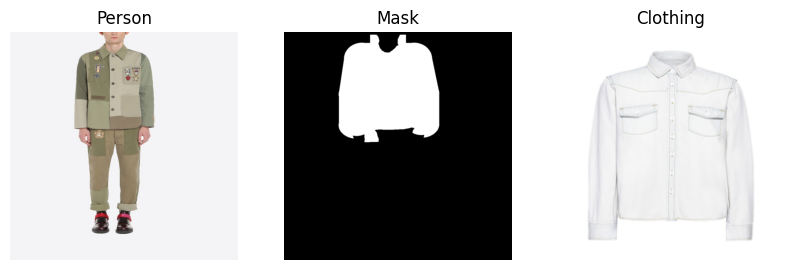

In [8]:
import matplotlib.pyplot as plt
fig, axes = plt.subplots(1, 3, figsize=(10, 5))

# Show images
axes[0].imshow(img, cmap='gray')
axes[0].axis('off')  # Hide axes for clarity
axes[0].set_title("Person")

axes[2].imshow(reference, cmap='gray')
axes[2].axis('off')  # Hide axes for clarity
axes[2].set_title("Clothing")

axes[1].imshow(mask, cmap='gray')
axes[1].axis('off')  # Hide axes for clarity
axes[1].set_title("Mask")

plt.show()

In [ ]:
img = torchvision.transforms.ToTensor()(img)
reference = torchvision.transforms.ToTensor()(reference)
mask = torchvision.transforms.ToTensor()(mask)
mask = 1-mask

densepose = torch.from_numpy(densepose['uv'])
densepose = torch.nn.functional.interpolate(densepose.unsqueeze(0), size=(512, 512), mode='bilinear', align_corners=True).squeeze(0)

img = torchvision.transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))(img)
reference = torchvision.transforms.Normalize((0.48145466, 0.4578275, 0.40821073),
                                            (0.26862954, 0.26130258, 0.27577711))(reference)
# densepose = torchvision.transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))(densepose)

inpaint = img * mask
hint = torchvision.transforms.Resize((512, 512))(reference)
hint = torch.cat((hint,densepose),dim = 0)

inpaint = inpaint.to(torch.float16).to(device).unsqueeze(0)
reference = reference.to(torch.float16).to(device).unsqueeze(0)
mask = mask.to(torch.float16).to(device).unsqueeze(0)
hint = hint.to(torch.float16).to(device).unsqueeze(0)
truth = img.to(torch.float16).to(device).unsqueeze(0)

In [ ]:
import traceback
with torch.no_grad(), precision_scope("cuda"):
    try:
        encoder_posterior_inpaint = model.first_stage_model.encode(inpaint)
        z_inpaint = model.scale_factor * (encoder_posterior_inpaint.sample()).detach()
        mask_resize = torchvision.transforms.Resize([z_inpaint.shape[-2],z_inpaint.shape[-1]])(mask)
        test_model_kwargs = {}
        test_model_kwargs['inpaint_image'] = z_inpaint
        test_model_kwargs['inpaint_mask'] = mask_resize
        shape = (model.channels, model.image_size, model.image_size)
        
        samples, _ = sampler.sample(S=opt.ddim, batch_size=1, shape=shape, pose=hint,
                            conditioning=reference, verbose=False, eta=0,
                            test_model_kwargs=test_model_kwargs)
        samples = 1. / model.scale_factor * samples
        x_samples = model.first_stage_model.decode(samples[:,:4,:,:])

        x_samples_ddim = torch.clamp((x_samples + 1.0) / 2.0, min=0.0, max=1.0)
        x_samples_ddim = x_samples_ddim.cpu().permute(0, 2, 3, 1).numpy()
        x_checked_image= x_samples_ddim
        x_checked_image_torch = torch.from_numpy(x_checked_image).permute(0, 3, 1, 2)                

        all_img=[]
        all_img_C = []
        mask = mask.cpu().permute(0, 2, 3, 1).numpy()
        mask = torch.from_numpy(mask).permute(0, 3, 1, 2)
        truth = torch.clamp((truth + 1.0) / 2.0, min=0.0, max=1.0)
        truth = truth.cpu().permute(0, 2, 3, 1).numpy()
        truth = torch.from_numpy(truth).permute(0, 3, 1, 2)
        x_checked_image_torch_C = x_checked_image_torch*(1-mask) + truth.cpu()*mask
        x_checked_image_torch = torch.nn.functional.interpolate(x_checked_image_torch.float(), size=[512,384])
        x_checked_image_torch_C = torch.nn.functional.interpolate(x_checked_image_torch_C.float(), size=[512,384])

        all_img.append(x_checked_image_torch[0])
        all_img_C.append(x_checked_image_torch_C[0])
        grid = torch.stack(all_img, 0)
        grid = torchvision.utils.make_grid(grid)
        grid = 255. * rearrange(grid, 'c h w -> h w c').cpu().numpy()
        img = Image.fromarray(grid.astype(np.uint8))
        img.save("results/Unpaired_Direst/1.png")

        grid_C = torch.stack(all_img_C, 0)
        grid_C = torchvision.utils.make_grid(grid_C)
        grid_C = 255. * rearrange(grid_C, 'c h w -> h w c').cpu().numpy()
        img_C = Image.fromarray(grid_C.astype(np.uint8))
        img_C.save("results/Unpaired_Concatenation/1.png")
    except Exception as e:
        print(f"An error occurred: {e}")
        traceback.print_exc()